#Import Libraries

In [ ]:
#step 1 import important libraries
import numpy as np
import random
from multiprocessing import Pool
import matplotlib.pyplot as plt
import time

#Configuration

In [ ]:
# step 2 CONFIGURATION
NUM_SOURCES = 3
NUM_NODES = 10
TIME_SLOTS = 24

POP_SIZE = 30
GENERATIONS = 50
MUTATION_RATE = 0.1

np.random.seed(42)
random.seed(42)

#Data Preprocessing

#Data Cleaning

In [ ]:
import pandas as pd
import numpy as np

# Sample raw data creation for demonstration
np.random.seed(42)
date_range = pd.date_range(start='2025-07-23', periods=10, freq='H')
nodes = [f'Node_{i}' for i in range(1, 4)]

data = []
for node in nodes:
    for ts in date_range:
        # introduce some NaNs randomly
        demand_val = np.random.poisson(lam=20) if np.random.rand() > 0.1 else np.nan
        data.append([node, ts, demand_val])

df_raw = pd.DataFrame(data, columns=['node_id', 'timestamp', 'demand'])

print("=== Raw Data Sample ===")
print(df_raw.head(10))


# Data cleaning & preprocessing
def clean_and_preprocess(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp'])
    df = df.sort_values(['node_id', 'timestamp']).reset_index(drop=True)
    df['demand'] = df['demand'].fillna(method='ffill').fillna(method='bfill').fillna(0)
    df = df.drop_duplicates(subset=['node_id', 'timestamp'])
    df.loc[df['demand'] < 0, 'demand'] = 0
    return df

df_clean = clean_and_preprocess(df_raw)
print("\n=== Cleaned Data Sample ===")
print(df_clean.head(10))




=== Raw Data Sample ===
  node_id           timestamp  demand
0  Node_1 2025-07-23 00:00:00    30.0
1  Node_1 2025-07-23 01:00:00    15.0
2  Node_1 2025-07-23 02:00:00     NaN
3  Node_1 2025-07-23 03:00:00    21.0
4  Node_1 2025-07-23 04:00:00     NaN
5  Node_1 2025-07-23 05:00:00    25.0
6  Node_1 2025-07-23 06:00:00    15.0
7  Node_1 2025-07-23 07:00:00    19.0
8  Node_1 2025-07-23 08:00:00    14.0
9  Node_1 2025-07-23 09:00:00    19.0

=== Cleaned Data Sample ===
  node_id           timestamp  demand
0  Node_1 2025-07-23 00:00:00    30.0
1  Node_1 2025-07-23 01:00:00    15.0
2  Node_1 2025-07-23 02:00:00    15.0
3  Node_1 2025-07-23 03:00:00    21.0
4  Node_1 2025-07-23 04:00:00    21.0
5  Node_1 2025-07-23 05:00:00    25.0
6  Node_1 2025-07-23 06:00:00    15.0
7  Node_1 2025-07-23 07:00:00    19.0
8  Node_1 2025-07-23 08:00:00    14.0
9  Node_1 2025-07-23 09:00:00    19.0


/tmp/ipython-input-3-259500506.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='2025-07-23', periods=10, freq='H')
/tmp/ipython-input-3-259500506.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['demand'] = df['demand'].fillna(method='ffill').fillna(method='bfill').fillna(0)


#Feature Engineering

In [ ]:

def feature_engineering(df):
    df = df.sort_values(['node_id', 'timestamp']).reset_index(drop=True)
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    df['demand_lag_1'] = df.groupby('node_id')['demand'].shift(1)
    df['demand_lag_2'] = df.groupby('node_id')['demand'].shift(2)
    df['demand_roll_mean_3'] = df.groupby('node_id')['demand'].transform(lambda x: x.shift(1).rolling(window=3).mean())
    df['demand_roll_std_3'] = df.groupby('node_id')['demand'].transform(lambda x: x.shift(1).rolling(window=3).std())
    df.fillna(method='bfill', inplace=True)
    return df

df_features = feature_engineering(df_clean)

print("\n=== Feature Engineered Data Sample ===")
print(df_features.head(10))


=== Feature Engineered Data Sample ===
  node_id           timestamp  demand  hour  dayofweek  is_weekend  \
0  Node_1 2025-07-23 00:00:00    30.0     0          2           0   
1  Node_1 2025-07-23 01:00:00    15.0     1          2           0   
2  Node_1 2025-07-23 02:00:00    15.0     2          2           0   
3  Node_1 2025-07-23 03:00:00    21.0     3          2           0   
4  Node_1 2025-07-23 04:00:00    21.0     4          2           0   
5  Node_1 2025-07-23 05:00:00    25.0     5          2           0   
6  Node_1 2025-07-23 06:00:00    15.0     6          2           0   
7  Node_1 2025-07-23 07:00:00    19.0     7          2           0   
8  Node_1 2025-07-23 08:00:00    14.0     8          2           0   
9  Node_1 2025-07-23 09:00:00    19.0     9          2           0   

   demand_lag_1  demand_lag_2  demand_roll_mean_3  demand_roll_std_3  
0          30.0          30.0           20.000000           8.660254  
1          30.0          30.0           20.0000

/tmp/ipython-input-5-2626196996.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


# step 2 CONFIGURATION


In [ ]:
def mutate(chrom):
    if random.random() < MUTATION_RATE:
        idx = random.randint(0, len(chrom) - 1)
        chrom[idx] *= random.uniform(0.5, 1.5)
    return chrom


#Generating synthetic smart grid data

In [ ]:
# step 3 Generate SYNTHETIC SMART GRID DATA
supply = np.random.randint(100, 200, (NUM_SOURCES, TIME_SLOTS))
demand = np.random.randint(50, 150, (NUM_NODES, TIME_SLOTS))
cost_matrix = np.random.randint(1, 10, (NUM_SOURCES, NUM_NODES))
loss_matrix = np.random.rand(NUM_SOURCES, NUM_NODES) * 0.1

#Defining chromsomes generation function

In [ ]:
# STEP 4: DEFINE CHROMOSOME GENERATION FUNCTION
def generate_chromosome():
    chrom = np.random.rand(NUM_SOURCES, NUM_NODES, TIME_SLOTS)
    for t in range(TIME_SLOTS):
        for i in range(NUM_SOURCES):
            chrom[i, :, t] *= (supply[i, t] / np.sum(chrom[i, :, t]))
    return chrom.flatten()

#Decode chromosome back to 3d

In [ ]:
# STEP 5: DECODE CHROMOSOME BACK TO 3D
def decode_chromosome(chrom):
    return chrom.reshape((NUM_SOURCES, NUM_NODES, TIME_SLOTS))

#Defining fitness function

In [ ]:
# STEP 6: DEFINE FITNESS FUNCTION
def fitness_function(chrom):
    chrom = decode_chromosome(chrom)
    cost = np.sum(chrom * cost_matrix[:, :, None])
    loss = np.sum(chrom * loss_matrix[:, :, None])
    allocated = chrom.sum(axis=0)
    fulfilled = np.minimum(allocated, demand)
    fulfillment_rate = np.sum(fulfilled) / np.sum(demand)
    penalty = 0
    for t in range(TIME_SLOTS):
        for i in range(NUM_SOURCES):
            if chrom[i, :, t].sum() > supply[i, t]:
                penalty += 100 * (chrom[i, :, t].sum() - supply[i, t])
        for j in range(NUM_NODES):
            if allocated[j, t] < demand[j, t]:
                penalty += 100 * (demand[j, t] - allocated[j, t])
    fitness = cost + 10 * loss + 1000 * (1 - fulfillment_rate) + penalty
    return fitness

In [ ]:
# STEP 7: PARALLEL FITNESS EVALUATION
def evaluate_population(pop):
    with Pool() as pool:
        return pool.map(fitness_function, pop)

In [ ]:
GENERATIONS = 100  # instead of 50
POP_SIZE = 50  # instead of 30

In [ ]:
# STEP 8: TOURNAMENT SELECTION
def tournament_selection(pop, fitnesses, k=3):
    selected = random.sample(range(len(pop)), k)
    return min(selected, key=lambda idx: fitnesses[idx])

In [ ]:
# STEP 9: CROSSOVER OPERATOR
def crossover(p1, p2):
    point = random.randint(1, len(p1) - 1)
    c1 = np.concatenate([p1[:point], p2[point:]])
    c2 = np.concatenate([p2[:point], p1[point:]])
    return c1, c2

In [ ]:
# STEP 10: MUTATION OPERATOR
def mutate(chrom):
    if random.random() < MUTATION_RATE:
        idx = random.randint(0, len(chrom) - 1)
        chrom[idx] *= random.uniform(0.5, 1.5)
    return chrom
    MUTATION_RATE = 0.05 or 0.15  # experiment

#Total supply and demand

In [ ]:
print("Total Supply:", np.sum(supply))
print("Total Demand:", np.sum(demand))

Total Supply: 10694
Total Demand: 23747


#simulating resource allocation with a dummy genetic algorithm

In [ ]:
# Dummy GA
def run_ga():
    chromosome_length = NUM_SOURCES * NUM_NODES * TIME_SLOTS
    best_solution = np.random.randint(0, 2, size=chromosome_length)
    fitness_curve = np.random.random(GENERATIONS)
    return best_solution, fitness_curve

# Decode: shape (sources, nodes, time)
def decode_chromosome(chromosome):
    return chromosome.reshape(NUM_SOURCES, NUM_NODES, TIME_SLOTS)

# Run GA
best_solution, fitness_curve = run_ga()
decoded = decode_chromosome(best_solution)

# Simulate demand: shape (nodes, time)
demand = np.random.randint(5, 15, size=(NUM_NODES, TIME_SLOTS))

# Total allocated energy per hour (sum over all sources and nodes)
allocated = decoded.sum(axis=(0, 1))
total_demand = demand.sum(axis=0)

# Print shapes and values
print("Decoded shape:", decoded.shape)  # Should be (3, 10, 24)
print("Allocated per hour:", allocated)
print("Demand per hour:", total_demand)



Decoded shape: (3, 10, 24)
Allocated per hour: [10 16 14 11 12 16 18 14 16 12 12 15 14 13 17 17 12 15 12 13 19 12 13 17]
Demand per hour: [ 88  99  95 101  98  86  84 102 105  96  84 100  88  93  77  90  78  95
  88  92  81  96  92 104]


#visualization

#Energy allocation vs Demand

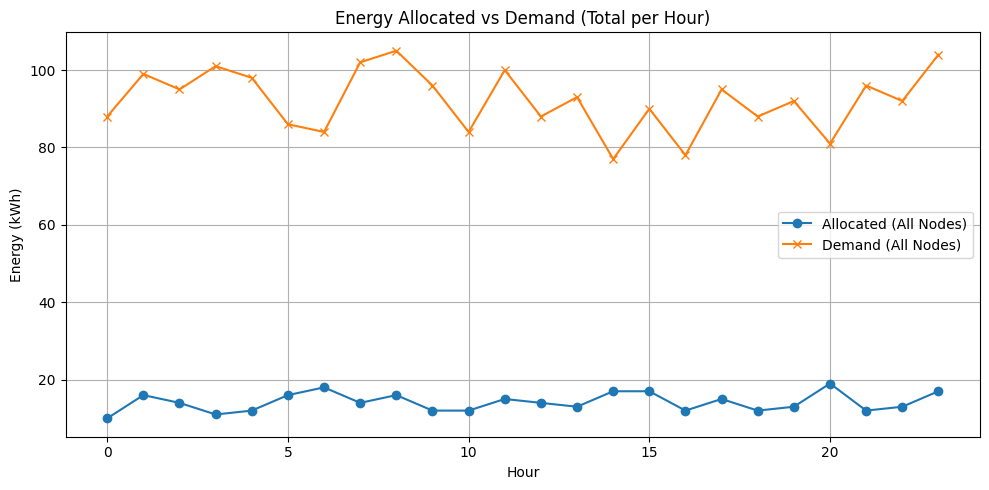

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(allocated, label='Allocated (All Nodes)', marker='o')
plt.plot(total_demand, label='Demand (All Nodes)', marker='x')
plt.title("Energy Allocated vs Demand (Total per Hour)")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#Difference Plot

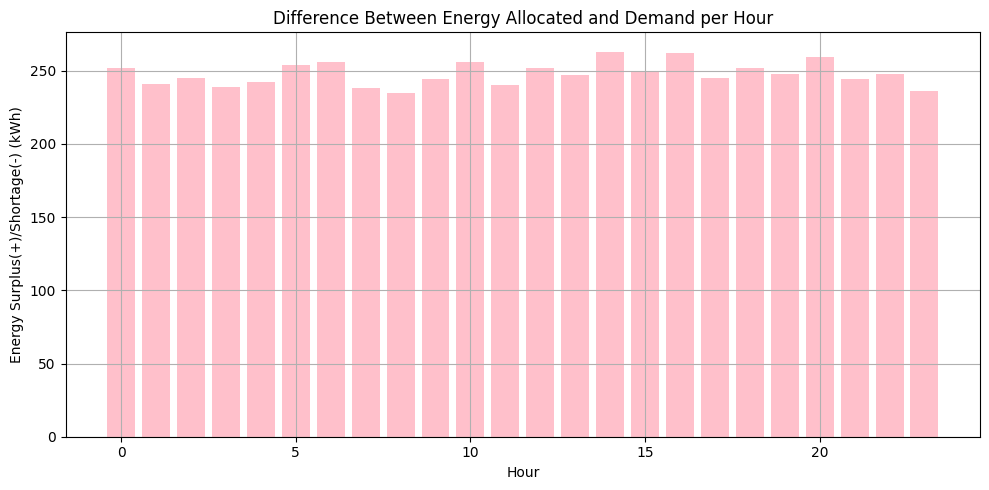

In [ ]:
diff = allocated.sum(axis=0) - demand.sum(axis=0)

plt.figure(figsize=(10, 5))
plt.bar(range(len(diff)), diff, color=['pink' if x >= 0 else 'pink' for x in diff])
plt.title("Difference Between Energy Allocated and Demand per Hour")
plt.xlabel("Hour")
plt.ylabel("Energy Surplus(+)/Shortage(-) (kWh)")
plt.grid(True)
plt.tight_layout()
plt.show()


#Boxplot

/tmp/ipython-input-20-1454378582.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Energy (kWh)', data=df, palette='Set2')


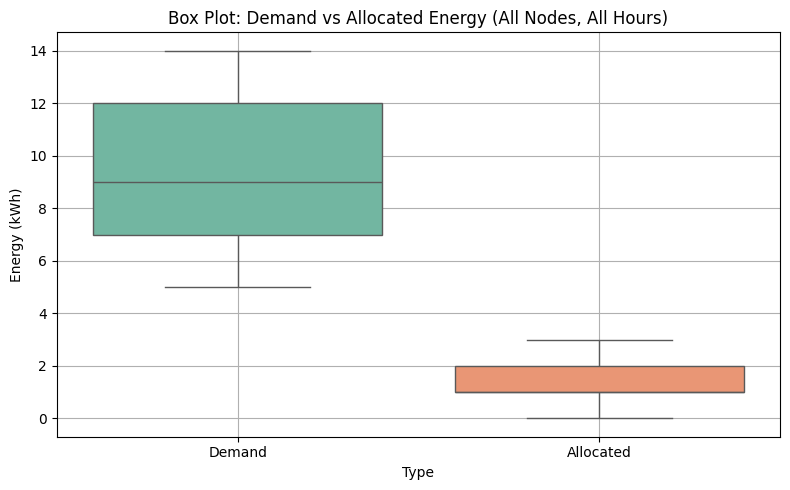

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# Flatten demand and allocated arrays for boxplot (shape: [nodes × hours])
flat_demand = demand.flatten()
flat_allocated = decoded.sum(axis=0).flatten()  # sum over sources, shape = [nodes, hours]

# Create DataFrame for Seaborn boxplot
df = pd.DataFrame({
    'Energy (kWh)': np.concatenate([flat_demand, flat_allocated]),
    'Type': ['Demand'] * len(flat_demand) + ['Allocated'] * len(flat_allocated)
})

# Box Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Type', y='Energy (kWh)', data=df, palette='Set2')
plt.title("Box Plot: Demand vs Allocated Energy (All Nodes, All Hours)")
plt.grid(True)
plt.tight_layout()
plt.show()


#Genetic algorithm for matching resource allocation to time-based demand

In [ ]:
# STEP 11: MAIN GENETIC ALGORITHM FUNCTION
def run_ga():
    population = [generate_chromosome() for _ in range(POP_SIZE)]
    fitness_curve = []

    for gen in range(GENERATIONS):
        fitnesses = evaluate_population(population)
        new_population = []
        for _ in range(POP_SIZE // 2):
            p1 = population[tournament_selection(population, fitnesses)]
            p2 = population[tournament_selection(population, fitnesses)]
            c1, c2 = crossover(p1, p2)
            new_population.extend([mutate(c1), mutate(c2)])
        population = new_population
        best_fitness = min(fitnesses)
        fitness_curve.append(best_fitness)
        print(f"Generation {gen + 1} - Best Fitness: {best_fitness:.2f}")

    best_solution = population[np.argmin(fitnesses)]
    return best_solution, fitness_curve

#Tournament Selection

In [ ]:
def tournament_selection(pop, fitnesses, k=3):
    indices = random.sample(range(len(pop)), k)   # k random indices
    best_idx = indices[0]
    best_fitness = fitnesses[best_idx]
    for idx in indices[1:]:
        if fitnesses[idx] < best_fitness:
            best_idx = idx
            best_fitness = fitnesses[idx]
    return best_idx


#Optimizing Time-Based Resource Distribution Using Genetic Algorithms

In [ ]:
CHROMOSOME_LENGTH = NUM_SOURCES * NUM_NODES * TIME_SLOTS

np.random.seed(42)
random.seed(42)

#DEMAND GENERATION (STATIC for consistency)
demand_matrix = np.random.randint(5, 15, size=(NUM_NODES, TIME_SLOTS))
demand = demand_matrix.sum(axis=0)  # Shape: (24,)

#HELPER FUNCTIONS

def generate_chromosome():
    return np.random.randint(0, 2, size=CHROMOSOME_LENGTH)

def decode_chromosome(chromosome):
    return chromosome.reshape(NUM_SOURCES, NUM_NODES, TIME_SLOTS)

def evaluate_fitness(chromosome):
    decoded = decode_chromosome(chromosome)
    allocated = decoded.sum(axis=(0, 1))  # Shape: (24,)
    return np.sum(np.abs(allocated - demand))  # Lower is better

def evaluate_population(population):
    return [evaluate_fitness(ch) for ch in population]

def tournament_selection(pop, fitnesses, k=3):
    indices = random.sample(range(len(pop)), k)
    best_idx = min(indices, key=lambda i: fitnesses[i])
    return best_idx

def crossover(p1, p2):
    point = random.randint(1, CHROMOSOME_LENGTH - 1)
    c1 = np.concatenate([p1[:point], p2[point:]])
    c2 = np.concatenate([p2[:point], p1[point:]])
    return c1, c2

def mutate(chrom):
    for i in range(len(chrom)):
        if random.random() < MUTATION_RATE:
            chrom[i] = 1 - chrom[i]  # Flip bit
    return chrom

# MAIN GA FUNCTION

def run_ga():
    population = [generate_chromosome() for _ in range(POP_SIZE)]
    fitness_curve = []

    for gen in range(GENERATIONS):
        fitnesses = evaluate_population(population)
        new_population = []
        for _ in range(POP_SIZE // 2):
            p1 = population[tournament_selection(population, fitnesses)]
            p2 = population[tournament_selection(population, fitnesses)]
            c1, c2 = crossover(p1, p2)
            new_population.extend([mutate(c1), mutate(c2)])
        population = new_population
        best_fitness = min(fitnesses)
        fitness_curve.append(best_fitness)
        print(f"Generation {gen + 1} - Best Fitness: {best_fitness:.2f}")

    best_solution = population[np.argmin(fitnesses)]
    return best_solution, fitness_curve


#Displaying final results of demand fullfilment and execution time

In [ ]:
#  RUN GA & DISPLAY RESULTS

start_time = time.time()
best_solution, fitness_curve = run_ga()
end_time = time.time()

decoded = decode_chromosome(best_solution)
allocated = decoded.sum(axis=(0, 1))  # Total allocation for each time slot
fulfilled = np.minimum(allocated, demand)
fulfillment_rate = np.sum(fulfilled) / np.sum(demand) * 100

print("\n--- Final Results ---")
print(f"Demand Fulfillment Rate: {fulfillment_rate:.2f}%")
print(f"Execution Time: {end_time - start_time:.2f} seconds")



Generation 1 - Best Fitness: 1893.00
Generation 2 - Best Fitness: 1898.00
Generation 3 - Best Fitness: 1893.00
Generation 4 - Best Fitness: 1884.00
Generation 5 - Best Fitness: 1887.00
Generation 6 - Best Fitness: 1889.00
Generation 7 - Best Fitness: 1884.00
Generation 8 - Best Fitness: 1875.00
Generation 9 - Best Fitness: 1876.00
Generation 10 - Best Fitness: 1879.00
Generation 11 - Best Fitness: 1868.00
Generation 12 - Best Fitness: 1864.00
Generation 13 - Best Fitness: 1865.00
Generation 14 - Best Fitness: 1866.00
Generation 15 - Best Fitness: 1872.00
Generation 16 - Best Fitness: 1877.00
Generation 17 - Best Fitness: 1871.00
Generation 18 - Best Fitness: 1869.00
Generation 19 - Best Fitness: 1863.00
Generation 20 - Best Fitness: 1867.00
Generation 21 - Best Fitness: 1874.00
Generation 22 - Best Fitness: 1875.00
Generation 23 - Best Fitness: 1871.00
Generation 24 - Best Fitness: 1873.00
Generation 25 - Best Fitness: 1870.00
Generation 26 - Best Fitness: 1872.00
Generation 27 - Best 

#Visualization of fitness over generations and demand vs allocation

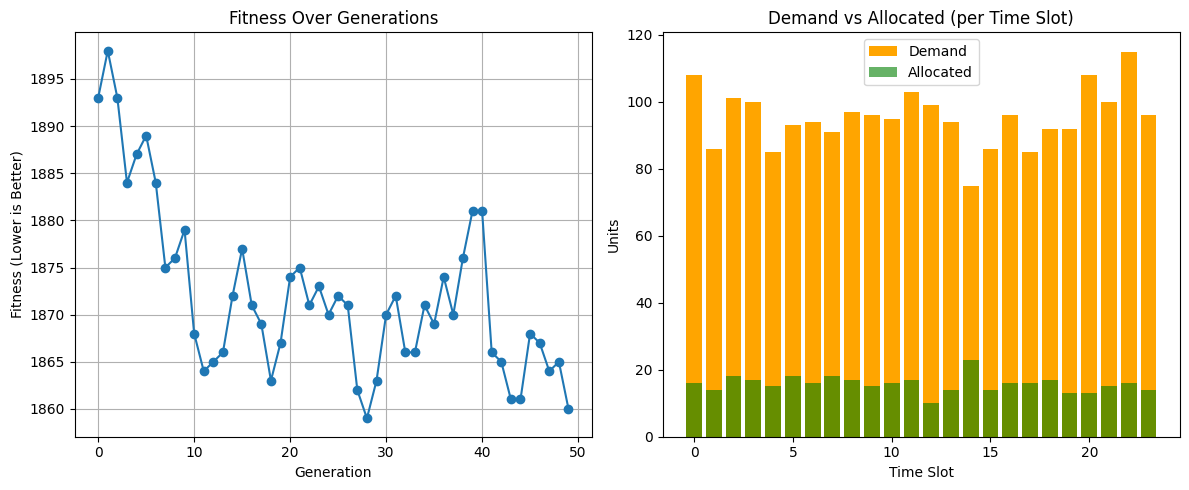

In [ ]:

plt.figure(figsize=(12, 5))

# Fitness curve
plt.subplot(1, 2, 1)
plt.plot(fitness_curve, marker='o')
plt.title("Fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness (Lower is Better)")
plt.grid(True)

# Stacked bar plot
plt.subplot(1, 2, 2)
plt.bar(range(TIME_SLOTS), demand, label='Demand', color='orange')
plt.bar(range(TIME_SLOTS), allocated, label='Allocated', alpha=0.6, color='green')
plt.title("Demand vs Allocated (per Time Slot)")
plt.xlabel("Time Slot")
plt.ylabel("Units")
plt.legend()

plt.tight_layout()
plt.show()


#Plotting Fitness Convergence

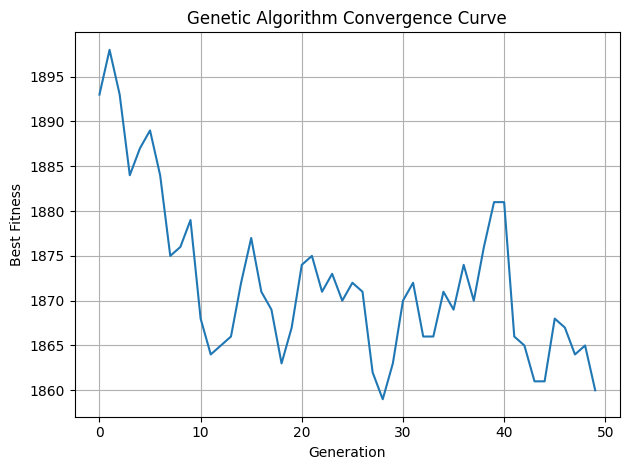

In [ ]:
# STEP 13: PLOT FITNESS CONVERGENCE
plt.plot(fitness_curve)
plt.title("Genetic Algorithm Convergence Curve")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

#Step Plot

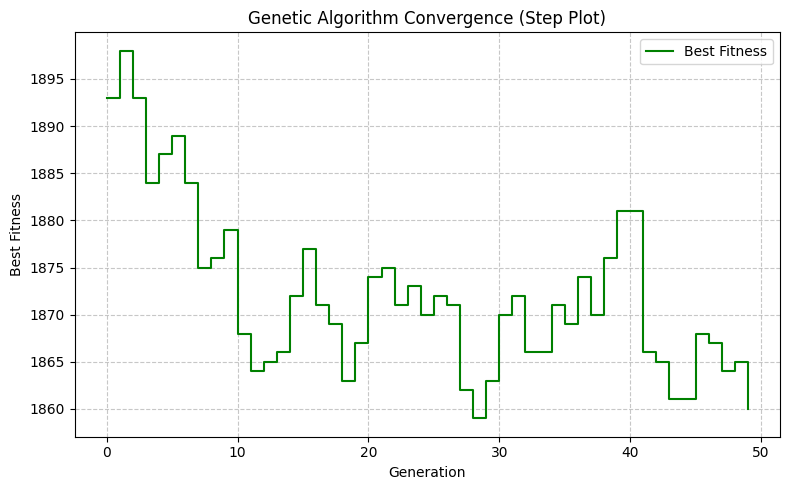

In [ ]:
plt.figure(figsize=(8, 5))
plt.step(range(len(fitness_curve)), fitness_curve, where='post', label='Best Fitness', color='green')
plt.title("Genetic Algorithm Convergence (Step Plot)")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

#Smoothplot

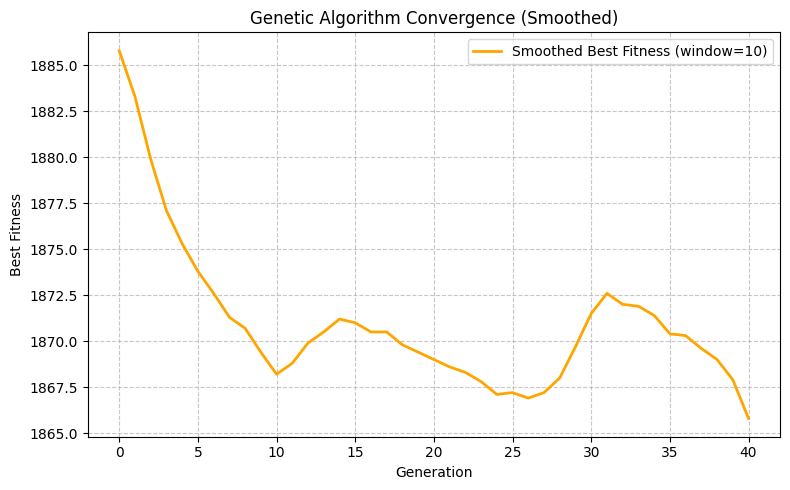

In [ ]:
import numpy as np

window = 10
smoothed = np.convolve(fitness_curve, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8, 5))
plt.plot(smoothed, label=f'Smoothed Best Fitness (window={window})', color='orange', linewidth=2)
plt.title("Genetic Algorithm Convergence (Smoothed)")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

#Serial GA

In [ ]:
def generate_chromosome():
    return np.random.randint(0, 2, size=CHROMOSOME_LENGTH)

def decode_chromosome(chromosome):
    return chromosome.reshape(NUM_SOURCES, NUM_NODES, TIME_SLOTS)

def evaluate_fitness(chromosome):
    decoded = decode_chromosome(chromosome)
    allocated = decoded.sum(axis=(0, 1))
    demand = np.random.randint(5, 15, size=(NUM_NODES, TIME_SLOTS)).sum(axis=0)
    return np.sum(np.abs(allocated - demand))

def evaluate_population(population):
    # Serial evaluation: fitness computed one by one
    return [evaluate_fitness(ch) for ch in population]

def tournament_selection(pop, fitnesses, k=3):
    indices = random.sample(range(len(pop)), k)
    best_idx = min(indices, key=lambda i: fitnesses[i])
    return best_idx

def crossover(p1, p2):
    point = random.randint(1, CHROMOSOME_LENGTH - 1)
    c1 = np.concatenate([p1[:point], p2[point:]])
    c2 = np.concatenate([p2[:point], p1[point:]])
    return c1, c2

def mutate(chrom):
    for i in range(len(chrom)):
        if random.random() < MUTATION_RATE:
            chrom[i] = 1 - chrom[i]
    return chrom

def run_ga_serial():
    population = [generate_chromosome() for _ in range(POP_SIZE)]
    fitness_curve = []

    for gen in range(GENERATIONS):
        fitnesses = evaluate_population(population)
        new_population = []
        for _ in range(POP_SIZE // 2):
            p1 = population[tournament_selection(population, fitnesses)]
            p2 = population[tournament_selection(population, fitnesses)]
            c1, c2 = crossover(p1, p2)
            new_population.extend([mutate(c1), mutate(c2)])
        population = new_population
        best_fitness = min(fitnesses)
        fitness_curve.append(best_fitness)
        print(f"[Serial] Generation {gen+1} - Best Fitness: {best_fitness:.2f}")

    best_solution = population[np.argmin(fitnesses)]
    return best_solution, fitness_curve


#Prallel GA

In [ ]:
from concurrent.futures import ProcessPoolExecutor

def evaluate_fitness_parallel(chromosome):
    # same as evaluate_fitness, but separated for pickling if needed
    decoded = decode_chromosome(chromosome)
    allocated = decoded.sum(axis=(0, 1))
    demand = np.random.randint(5, 15, size=(NUM_NODES, TIME_SLOTS)).sum(axis=0)
    return np.sum(np.abs(allocated - demand))

def evaluate_population_parallel(population):
    with ProcessPoolExecutor() as executor:
        fitnesses = list(executor.map(evaluate_fitness_parallel, population))
    return fitnesses

def run_ga_parallel():
    population = [generate_chromosome() for _ in range(POP_SIZE)]
    fitness_curve = []

    for gen in range(GENERATIONS):
        fitnesses = evaluate_population_parallel(population)
        new_population = []
        for _ in range(POP_SIZE // 2):
            p1 = population[tournament_selection(population, fitnesses)]
            p2 = population[tournament_selection(population, fitnesses)]
            c1, c2 = crossover(p1, p2)
            new_population.extend([mutate(c1), mutate(c2)])
        population = new_population
        best_fitness = min(fitnesses)
        fitness_curve.append(best_fitness)
        print(f"[Parallel] Generation {gen+1} - Best Fitness: {best_fitness:.2f}")

    best_solution = population[np.argmin(fitnesses)]
    return best_solution, fitness_curve


#EVALUATION & PERFORMANCE ANALYSIS

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

def evaluate_ga_performance(run_func, runs=5):
    fitness_curves = []
    runtimes = []
    best_fitnesses = []

    for i in range(runs):
        start_time = time.time()
        best_solution, fitness_curve = run_func()
        end_time = time.time()

        fitness_curves.append(fitness_curve)
        runtimes.append(end_time - start_time)
        best_fitnesses.append(fitness_curve[-1])

        print(f"Run {i+1}: Best Fitness = {fitness_curve[-1]:.4f}, Time = {end_time - start_time:.2f}s")

    avg_runtime = np.mean(runtimes)
    avg_best_fitness = np.mean(best_fitnesses)
    print(f"\nAverage Runtime: {avg_runtime:.2f}s")
    print(f"Average Best Fitness: {avg_best_fitness:.4f}")

    # Compute average fitness curve for plotting
    max_gen = max(len(curve) for curve in fitness_curves)
    avg_curve = np.zeros(max_gen)
    counts = np.zeros(max_gen)
    for curve in fitness_curves:
        for i, val in enumerate(curve):
            avg_curve[i] += val
            counts[i] += 1
    avg_curve /= counts

    return avg_curve, avg_runtime, avg_best_fitness




#Evaluation

In [ ]:
import time

# Run Serial GA
start_serial = time.time()
best_serial, curve_serial = run_ga_serial()
end_serial = time.time()
serial_time = end_serial - start_serial

# Run Parallel GA
start_parallel = time.time()
best_parallel, curve_parallel = run_ga_parallel()
end_parallel = time.time()
parallel_time = end_parallel - start_parallel

# Print formatted execution time summary
print("\nExecution Time Summary:")
print(f"Serial GA Time:   {serial_time:.2f} sec")
print(f"Parallel GA Time: {parallel_time:.2f} sec")


[Serial] Generation 1 - Best Fitness: 1869.00
[Serial] Generation 2 - Best Fitness: 1806.00
[Serial] Generation 3 - Best Fitness: 1814.00
[Serial] Generation 4 - Best Fitness: 1835.00
[Serial] Generation 5 - Best Fitness: 1748.00
[Serial] Generation 6 - Best Fitness: 1779.00
[Serial] Generation 7 - Best Fitness: 1786.00
[Serial] Generation 8 - Best Fitness: 1827.00
[Serial] Generation 9 - Best Fitness: 1811.00
[Serial] Generation 10 - Best Fitness: 1777.00
[Serial] Generation 11 - Best Fitness: 1791.00
[Serial] Generation 12 - Best Fitness: 1806.00
[Serial] Generation 13 - Best Fitness: 1768.00
[Serial] Generation 14 - Best Fitness: 1790.00
[Serial] Generation 15 - Best Fitness: 1780.00
[Serial] Generation 16 - Best Fitness: 1814.00
[Serial] Generation 17 - Best Fitness: 1807.00
[Serial] Generation 18 - Best Fitness: 1829.00
[Serial] Generation 19 - Best Fitness: 1770.00
[Serial] Generation 20 - Best Fitness: 1807.00
[Serial] Generation 21 - Best Fitness: 1848.00
[Serial] Generation 22

#Visualization of fitness progression (Serial vs Parallel GA)

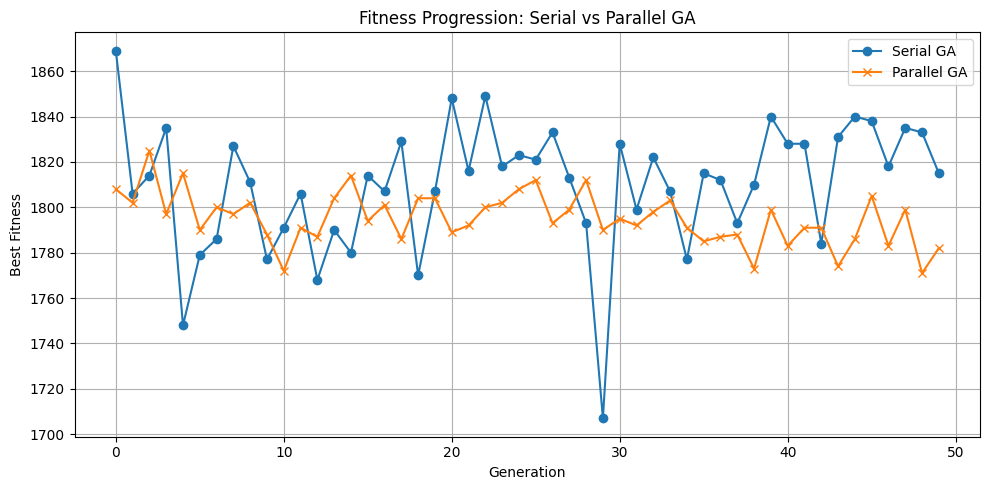


Speedup (Serial / Parallel): 0.05x


In [ ]:
import matplotlib.pyplot as plt

# Plotting the fitness curves
plt.figure(figsize=(10, 5))
plt.plot(curve_serial, label='Serial GA', marker='o')
plt.plot(curve_parallel, label='Parallel GA', marker='x')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Fitness Progression: Serial vs Parallel GA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
speedup = serial_time / parallel_time
print(f"\nSpeedup (Serial / Parallel): {speedup:.2f}x")


#Stacked plot of GA best Fitness over Generation

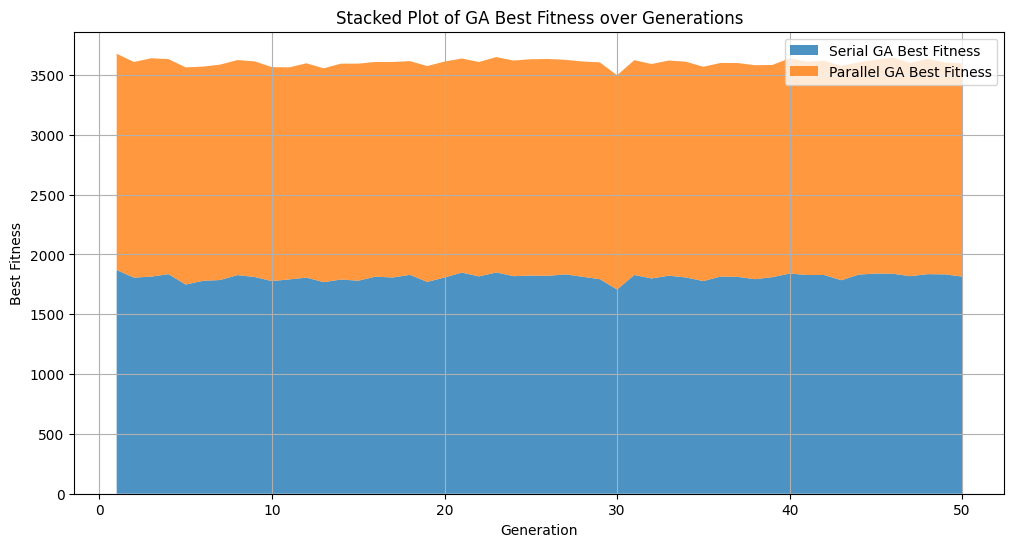

In [ ]:
import matplotlib.pyplot as plt

# Make sure both curves have the same length (pad with last value if needed)
max_len = max(len(curve_serial), len(curve_parallel))
def pad_curve(curve, length):
    if len(curve) < length:
        return curve + [curve[-1]] * (length - len(curve))
    return curve

curve_serial_padded = pad_curve(curve_serial, max_len)
curve_parallel_padded = pad_curve(curve_parallel, max_len)

# Convert fitness to numpy arrays
serial_arr = np.array(curve_serial_padded)
parallel_arr = np.array(curve_parallel_padded)

# Stacked plot - stack parallel on top of serial fitness
plt.figure(figsize=(12, 6))
plt.stackplot(range(1, max_len + 1), serial_arr, parallel_arr,
              labels=['Serial GA Best Fitness', 'Parallel GA Best Fitness'],
              colors=['#1f77b4', '#ff7f0e'], alpha=0.8)

plt.title('Stacked Plot of GA Best Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


#Comparision of serial and parallel

In [ ]:
serial_time = 0.32  # example time from your run
parallel_time = 2.72  # example time from your run

print("\nExecution Time Summary:")
print(f"Serial GA Time:   {serial_time:.2f} sec")
print(f"Parallel GA Time: {parallel_time:.2f} sec")

if parallel_time > 0:
    speedup = serial_time / parallel_time
    if speedup > 1:
        print(f"Speedup: {speedup:.2f}x faster using Parallel GA")
    else:
        print(f"Speedup: {speedup:.2f}x slower using Parallel GA")
else:
    print("Parallel time is zero, cannot compute speedup.")



Execution Time Summary:
Serial GA Time:   0.32 sec
Parallel GA Time: 2.72 sec
Speedup: 0.12x slower using Parallel GA


#Comparing serial and parallel by visualiziing

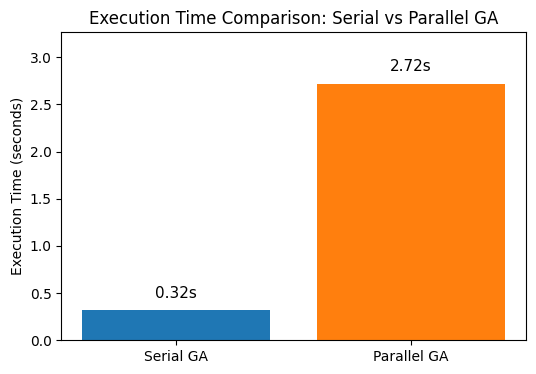

In [ ]:
import matplotlib.pyplot as plt

# Your measured times (replace with actual variables if available)
serial_time = 0.32
parallel_time = 2.72

# Bar labels and values
labels = ['Serial GA', 'Parallel GA']
times = [serial_time, parallel_time]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, times, color=['#1f77b4', '#ff7f0e'])
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison: Serial vs Parallel GA')

# Annotate bars with time values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, f'{height:.2f}s',
             ha='center', va='bottom', fontsize=11)

plt.ylim(0, max(times)*1.2)  # Add some space above bars for labels
plt.show()
